In [39]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from utils import save_config

pd.set_option('display.max_rows', 150)
ID = 1

In [40]:
rand_seed = 42

In [41]:
prj_folder = Path('.').resolve()
prj_folder

WindowsPath('C:/Users/pavel/OneDrive/Desktop/it_cup')

In [76]:
data = pd.read_csv(prj_folder/'2. Cup_IT_2022_Датасет_Data_Science.csv')

In [77]:
num_nans = data.isna().sum()
num_total = data.shape[0]
skip_rate = (num_nans / num_total * 100).sort_values(ascending=True)
keys = skip_rate[skip_rate < 101].keys()

In [78]:
data = data[keys]

In [79]:
X = data.iloc[:, 2:]
y = data.iloc[:, 1]

X = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-99999).fit_transform(X)
#X = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=10000).fit_transform(X)
#X = SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(X)
#X = StandardScaler().fit_transform(X)

In [46]:
# from sklearn.cluster import KMeans
# clusters = KMeans(random_state=rand_seed, n_clusters=40).fit_transform(X)
# X = np.concatenate((X, clusters), axis=1)

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=False, train_size=0.7, random_state=42)

In [48]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, recall_score, precision_score
precision_score(y, np.zeros_like(y))

C:\Users\pavel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [67]:
rf_config = {
    'n_estimators': [200],
    #'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'max_depth' : [6, 10, 12],
    'criterion' :['entropy'],
    'class_weight': ['balanced']
}

gb_config = {
    'learning_rate': [0.1],
    'n_estimators': [100],
    'max_depth' : [3],
    'subsample': [1]
}

gpc_config = {
    #'C': [0.5],
}

scoring = ['accuracy', 'f1', 'roc_auc', 'precision', 'recall']

In [68]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

clf = RandomForestClassifier(random_state=rand_seed, n_jobs=8)
#clf = GradientBoostingClassifier(random_state=rand_seed)
#clf = LGBMClassifier(random_state=rand_seed, class_weight='balanced')
#clf = LogisticRegression(random_state=rand_seed, class_weight={0: 0.1, 1: 0.9}, n_jobs=-1)
#clf = SVC(kernel='rbf', class_weight='balanced',cache_size=1000)

In [69]:
CUR_CONFIG = rf_config

save_config(ID, CUR_CONFIG, clf)
ID += 1

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=rand_seed)
#validator = GridSearchCV(clf, param_grid=CUR_CONFIG, scoring=scoring, n_jobs=4, cv=cv, refit='f1', verbose=2)

In [70]:
clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=8, random_state=42)

In [71]:
print(validator.best_estimator_)
print(validator.best_params_)
print(validator.best_score_)
print(validator.cv_results_)


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, n_estimators=200, n_jobs=8,
                       random_state=42)
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
0.2947217165444282
{'mean_fit_time': array([83.21224737, 65.86070689]), 'std_fit_time': array([ 0.78224806, 17.34816163]), 'mean_score_time': array([3.60303378, 2.4112188 ]), 'std_score_time': array([0.25291048, 2.09365237]), 'param_class_weight': masked_array(data=['balanced', 'balanced'],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'param_criterion': masked_array(data=['entropy', 'entropy'],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[10, 12],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'param_min_samples_leaf': masked_arr

In [72]:
from utils import fine_print
fine_print(validator.cv_results_)

m_acc:     [0.76264517 0.8227666 ]
m_f1:      [0.29472172 0.27777265]
m_rauc:    [0.71443433 0.70768753]
m_prec:    [0.21029034 0.23555372]
m_recall:  [0.49259157 0.33855144]


In [73]:
from sklearn.metrics import confusion_matrix
preds = validator.predict_proba(X_val)

print(preds[:2])

preds[:, 0] -= 0.0
preds[:, 1] += 0.0

print(preds[:2])

preds = np.argmax(preds, axis=-1)

confusion_matrix(y_val, preds)

[[0.70965567 0.29034433]
 [0.6761321  0.3238679 ]]
[[0.70965567 0.29034433]
 [0.6761321  0.3238679 ]]


array([[31755,  5863],
       [ 1595,  1306]], dtype=int64)

In [74]:
print(accuracy_score(y_val, preds))
print(f1_score(y_val, preds))
print(roc_auc_score(y_val, preds))
print(precision_score(y_val, preds))
print(recall_score(y_val, preds))

0.8159382018312397
0.25938430983118177
0.6471666753810587
0.18217324591993306
0.4501895897966219


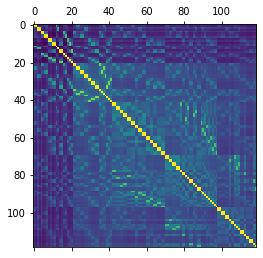

In [75]:
import matplotlib.pyplot as plt
plt.matshow(pd.DataFrame(X).corr())
plt.show()